# Data stats and augmentations

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
os.environ['THEANO_FLAGS'] = 'device=cpu'

from data_utils import TRAIN_CSV_FILEPATH, TRAIN_CSV, TRAIN_ENC_CSV, get_caption, train_jpg_ids
from image_utils import get_image_data

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

In [5]:
TRAIN_ENC_CSV.head()

image_name                                       tags  bare_ground  clear  \
0    train_0                               haze primary            0      0   
1    train_1            agriculture clear primary water            0      1   
2    train_2                              clear primary            0      1   
3    train_3                              clear primary            0      1   
4    train_4  agriculture clear habitation primary road            0      1   

   primary  blow_down  cultivation  water  slash_burn  partly_cloudy  \
0        1          0            0      0           0              0   
1        1          0            0      1           0              0   
2        1          0            0      0           0              0   
3        1          0            0      0           0              0   
4        1          0            0      0           0              0   

   habitation  conventional_mine  blooming  selective_logging  cloudy  \
0           0                  0         0                  0       0   
1           0                  0         0                  0       0   
2           0                  0         0                  0       0   
3           0                  0         0                  0       0   
4           1                  0         0                  0       0   

   artisinal_mine  road  haze  agriculture  
0               0     0     1            0  
1               0     0     0            1  
2               0     0     0            0  
3               0     0     0            0  
4               0     1     0            1

In [74]:
img = get_image_data("0", "Train_jpg")
img.min(), img.max(), img.dtype

(75, 126, dtype('uint8'))

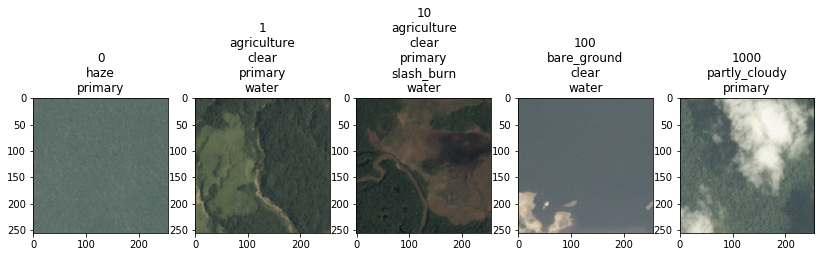

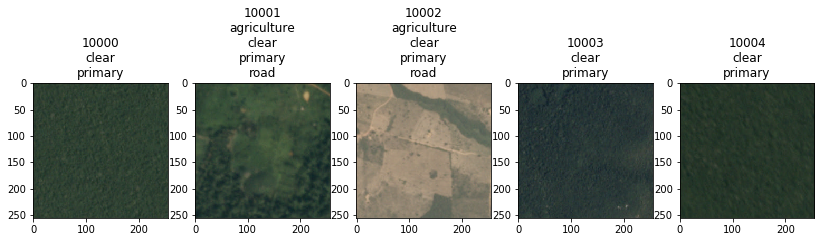

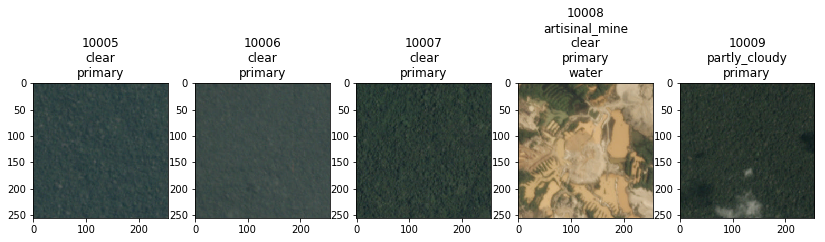

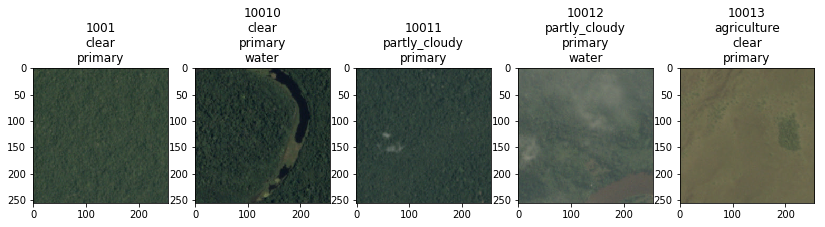

In [7]:
n = 5
counter = 0
for image_id in train_jpg_ids[:20]:
    img = get_image_data(image_id, "Train_jpg")
    caption = get_caption(image_id, "Train_jpg")
    if counter % n == 0:
        plt.figure(figsize=(14, 5))
    plt.subplot(1, n, counter % n + 1)
    plt.imshow(img[:,:,:3])
    plt.title(image_id + "\n" + caption.replace(' ', '\n'))
    counter += 1

## Data stats

In [5]:
from data_utils import unique_tags

In [9]:
def compute_stats(tags=None, train_enc_csv=TRAIN_ENC_CSV):
    if tags is None:
        tags = unique_tags
    tags_stats = {}
    for l in tags:
        tags_stats[l] = train_enc_csv[l].sum()
    return tags_stats

In [10]:
all_tags_stats = compute_stats()
all_tags_stats

{'agriculture': 12315,
 'artisinal_mine': 339,
 'bare_ground': 862,
 'blooming': 332,
 'blow_down': 98,
 'clear': 28431,
 'cloudy': 2089,
 'conventional_mine': 100,
 'cultivation': 4477,
 'habitation': 3660,
 'haze': 2697,
 'partly_cloudy': 7261,
 'primary': 37513,
 'road': 8071,
 'selective_logging': 340,
 'slash_burn': 209,
 'water': 7411}

<Container object of 17 artists>

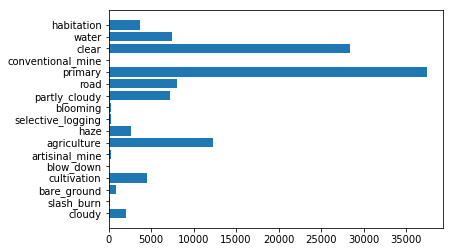

In [11]:
plt.barh(bottom=range(len(all_tags_stats.keys())), width=all_tags_stats.values(), tick_label=all_tags_stats.keys())

### Separate data to equalize stats

In [12]:
all_tags_stats

{'agriculture': 12315,
 'artisinal_mine': 339,
 'bare_ground': 862,
 'blooming': 332,
 'blow_down': 98,
 'clear': 28431,
 'cloudy': 2089,
 'conventional_mine': 100,
 'cultivation': 4477,
 'habitation': 3660,
 'haze': 2697,
 'partly_cloudy': 7261,
 'primary': 37513,
 'road': 8071,
 'selective_logging': 340,
 'slash_burn': 209,
 'water': 7411}

In [13]:
from data_utils import equalized_data_classes as data_classes

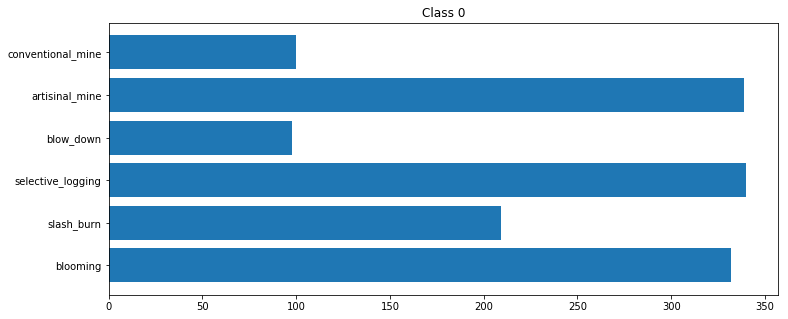

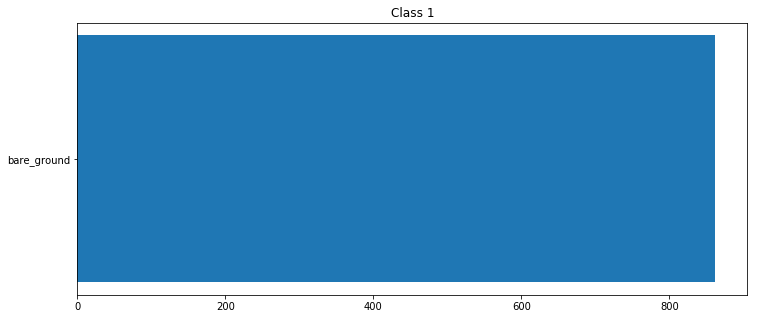

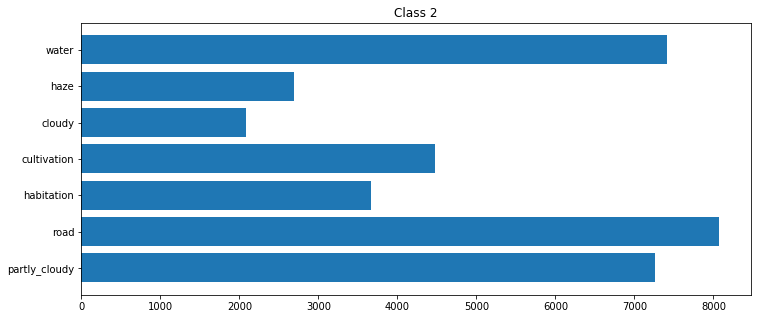

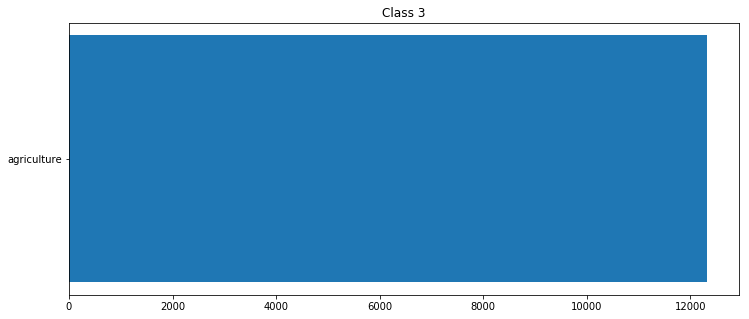

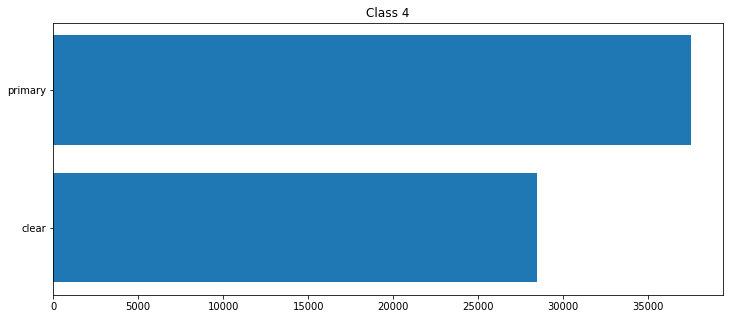

In [14]:
for class_index in data_classes:    
    tags = data_classes[class_index]
    tags_stats = compute_stats(tags)
    plt.figure(figsize=(12, 5))
    plt.title("Class %i" % class_index)
    plt.barh(bottom=range(len(tags_stats.keys())), width=tags_stats.values(), tick_label=list(tags_stats.keys()))

## Data augmentation

In [34]:
import cv2
from image_utils import scale_percentile

from keras import backend as K
from training_utils import get_gen_flow, get_train_imgaug_seq
from data_utils import TRAIN_ENC_CL_CSV, get_id_type_list, equalized_data_classes

In [30]:
TRAIN_ENC_CL_CSV.head()

image_name                                       tags  cloudy  slash_burn  \
0    train_0                               haze primary       0           0   
1    train_1            agriculture clear primary water       0           0   
2    train_2                              clear primary       0           0   
3    train_3                              clear primary       0           0   
4    train_4  agriculture clear habitation primary road       0           0   

   cultivation  blow_down  artisinal_mine  agriculture  haze  \
0            0          0               0            0     1   
1            0          0               0            1     0   
2            0          0               0            0     0   
3            0          0               0            0     0   
4            0          0               0            1     0   

   conventional_mine    ...     habitation  selective_logging  clear  water  \
0                  0    ...              0                  0      0      0   
1                  0    ...              0                  0      1      1   
2                  0    ...              0                  0      1      0   
3                  0    ...              0                  0      1      0   
4                  0    ...              1                  0      1      0   

   class_0  class_1  class_2  class_3  class_4  image_id  
0        0        0        1        0        1         0  
1        0        0        1        1        1         1  
2        0        0        0        0        1         2  
3        0        0        0        0        1         3  
4        0        0        1        1        1         4  

[5 rows x 25 columns]

In [35]:
equalized_data_classes

{0: ['selective_logging',
  'slash_burn',
  'blow_down',
  'blooming',
  'conventional_mine',
  'artisinal_mine'],
 1: ['bare_ground'],
 2: ['haze',
  'water',
  'partly_cloudy',
  'cultivation',
  'road',
  'habitation',
  'cloudy'],
 3: ['agriculture'],
 4: ['primary', 'clear']}

In [17]:
df = TRAIN_ENC_CL_CSV[TRAIN_ENC_CL_CSV['class_0'] == 1]

class_0_stats = compute_stats(train_enc_csv=df)
class_0_stats

{'agriculture': 292,
 'artisinal_mine': 339,
 'bare_ground': 75,
 'blooming': 332,
 'blow_down': 98,
 'clear': 1232,
 'cloudy': 0,
 'conventional_mine': 100,
 'cultivation': 241,
 'habitation': 122,
 'haze': 19,
 'partly_cloudy': 142,
 'primary': 1372,
 'road': 362,
 'selective_logging': 340,
 'slash_burn': 209,
 'water': 406}

<Container object of 17 artists>

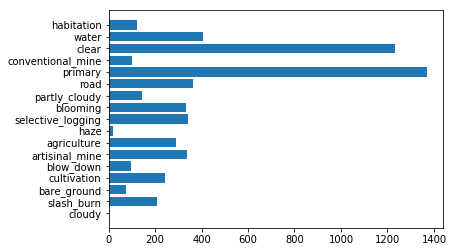

In [31]:
plt.barh(bottom=range(len(class_0_stats.keys())), width=class_0_stats.values(), tick_label=class_0_stats.keys())

In [32]:
id_type_list = get_id_type_list(0)

In [33]:
id_type_list[:10]

[(10, 'Train_jpg'),
 (24, 'Train_jpg'),
 (57, 'Train_jpg'),
 (70, 'Train_jpg'),
 (82, 'Train_jpg'),
 (144, 'Train_jpg'),
 (151, 'Train_jpg'),
 (166, 'Train_jpg'),
 (185, 'Train_jpg'),
 (187, 'Train_jpg')]

### Display images with data_iterator

In [24]:
train_id_type_list = id_type_list

In [26]:
n_limit = 10

params = {
    'seed': 2017,
    'normalize_data': True,
    'normalization': 'vgg',
    'image_size': (256, 256),
    'batch_size': 5,
    'save_prefix': 'check_data_iterators'
}
channels_first = K.image_dim_ordering() == 'th'

In [27]:
imgaug_seq = get_train_imgaug_seq(seed=params['seed'])
train_gen, train_flow = get_gen_flow(id_type_list=train_id_type_list[:n_limit], imgaug_seq=imgaug_seq, **params)

Image normalization:  vgg


(5, 256, 256, 3) (5, 17)
-39.2715 47.7091
(5, 256, 256, 3) (5, 17)
-48.8267 28.7777
(5, 256, 256, 3) (5, 17)
-51.744 37.3638
(5, 256, 256, 3) (5, 17)
-37.1002 41.9326
(5, 256, 256, 3) (5, 17)
-45.6021 28.7138


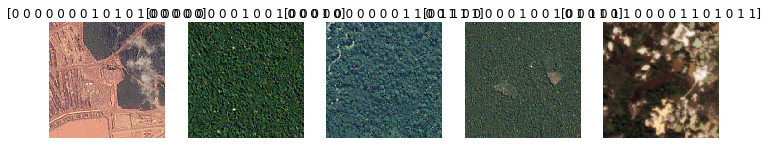

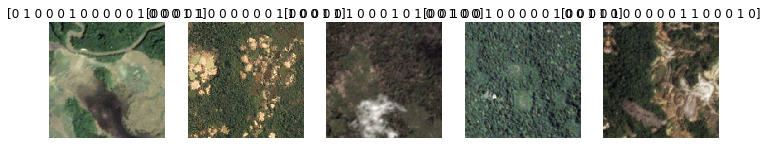

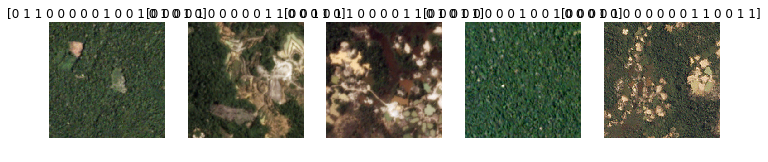

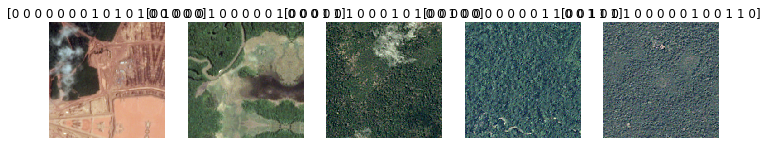

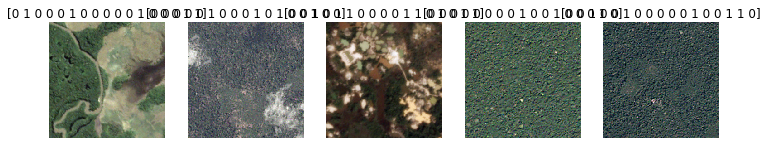

In [28]:
loop_max_counter = 5
for x, y in train_flow:
    
    print(x.shape, y.shape)
    print(x.mean(), x.std())
    n = 5
    for counter in range(params['batch_size']):
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        plt.imshow(scale_percentile(img, q_min=0.0, q_max=100.0))
#         plt.imshow(img)
        plt.title("{}".format(y[counter]))    
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

## White pixels

In [38]:
from data_utils import get_id_type_list_from_df

In [42]:
cloudy_mask = TRAIN_ENC_CL_CSV['cloudy'] == 1
partly_cloudy_mask = TRAIN_ENC_CL_CSV['partly_cloudy'] == 1
df = TRAIN_ENC_CL_CSV[cloudy_mask | partly_cloudy_mask]

In [44]:
df[['image_id', 'cloudy', 'partly_cloudy']].tail()

image_id  cloudy  partly_cloudy
40455     40455       0              1
40461     40461       1              0
40464     40464       0              1
40475     40475       1              0
40478     40478       0              1

In [45]:
id_type_list = get_id_type_list_from_df(df)

In [46]:
len(id_type_list)

9350

In [51]:
train_id_type_list = id_type_list

In [75]:
n_limit = -1

params = {
    'seed': 2017,
    'normalize_data': False,
    'normalization': '',
    'image_size': (256, 256),
    'batch_size': 5,
    'save_prefix': 'check_data_iterators'
}
channels_first = K.image_dim_ordering() == 'th'

In [76]:
from training_utils import get_id_imgaug_seq

In [77]:
import numpy as np
import cv2

def to_hsl(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [93]:
imgaug_seq = get_id_imgaug_seq()
train_gen, train_flow = get_gen_flow(id_type_list=train_id_type_list[:n_limit], imgaug_seq=imgaug_seq, **params)

-- (5, 256, 256, 3) (5, 17)
-- 0.0901961 0.905882 0.483697 0.180606
-- (5, 256, 256, 3) (5, 17)
-- 0.0862745 0.870588 0.390886 0.127664
-- (5, 256, 256, 3) (5, 17)
-- 0.141176 0.980392 0.471123 0.137622
-- (5, 256, 256, 3) (5, 17)
-- 0.129412 0.905882 0.525571 0.195301
-- (5, 256, 256, 3) (5, 17)
-- 0.0117647 0.909804 0.366732 0.169534


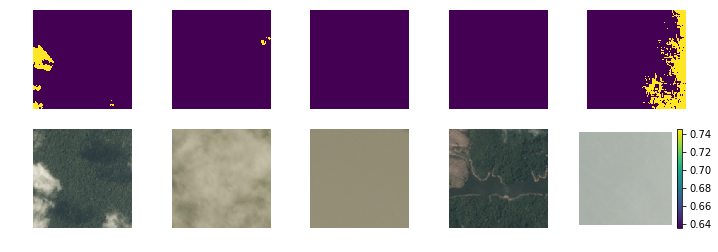

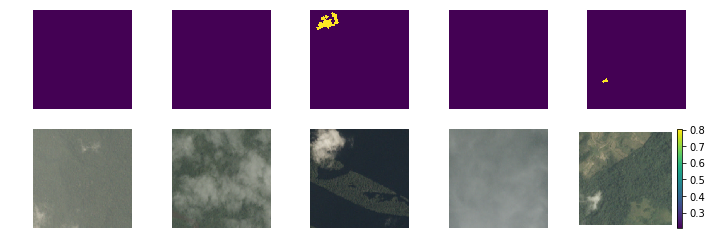

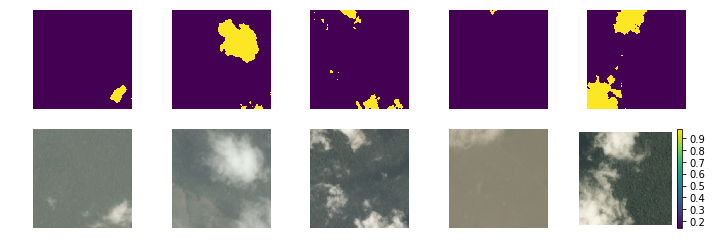

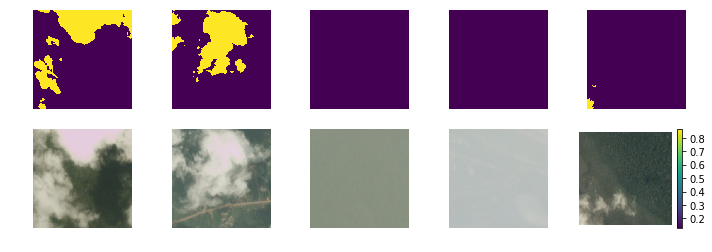

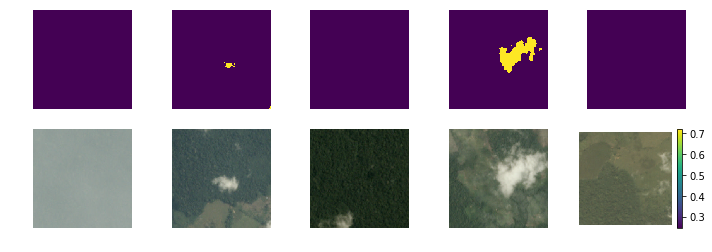

In [107]:
loop_max_counter = 5
for x, y in train_flow:
    
    print('--', x.shape, y.shape)
    print('--', x.min(), x.max(), x.mean(), x.std())
        
    n = 5
    for counter in range(params['batch_size']):
        if counter % n == 0:
            plt.figure(figsize=(12, 4))

        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        
#         img2 = scale_percentile(img, q_min=0.0, q_max=100.0)
        img2 = (255.0 * img).astype(np.uint8)
        hls = to_hsl(img2)
        
        l = hls[:, :, 1]
#         print(l.min(), l.mean(), l.max()) 
        l[l > 180] = 255
        l[l <= 180] = 0
        img2 = l 

        plt.subplot(2, n, counter % n + 1)
#         plt.imshow(scale_percentile(img2, q_min=0.0, q_max=100.0))
        plt.imshow(img2)
#         plt.title("{}".format(y[counter]))    
        plt.axis('off')
        
        plt.subplot(2, n, counter % n + n + 1)    
        plt.imshow(img)
        plt.axis('off')
    
    plt.colorbar()
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

In [9]:
import numpy as np

In [3]:
a = np.zeros((32, 17))
a[1] = 1.0
b = 0.5 * np.ones((32, 17))

In [6]:
np.mean(np.abs(a - b))

0.5

In [7]:
from data_utils import equalized_data_classes, get_label, get_id_type_list_for_class

In [10]:
id_type_list = np.array(get_id_type_list_for_class(0))

In [17]:
get_label(*id_type_list[1], as_series=True, class_index=0), get_label(*id_type_list[1], as_series=True)

(selective_logging    0
 slash_burn           0
 blow_down            0
 blooming             0
 conventional_mine    1
 artisinal_mine       0
 Name: 24, dtype: object, agriculture          0
 artisinal_mine       0
 bare_ground          0
 blooming             0
 blow_down            0
 clear                0
 cloudy               0
 conventional_mine    1
 cultivation          0
 habitation           0
 haze                 0
 partly_cloudy        1
 primary              1
 road                 0
 selective_logging    0
 slash_burn           0
 water                0
 Name: 24, dtype: object)

In [12]:
equalized_data_classes[0]

['selective_logging',
 'slash_burn',
 'blow_down',
 'blooming',
 'conventional_mine',
 'artisinal_mine']

In [16]:
unique_tags

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

## Rare classes

In [8]:
from data_utils import get_id_type_list_from_df, TRAIN_ENC_CL_CSV, equalized_data_classes, get_id_type_list_for_class
from xy_providers import image_class_labels_provider

In [9]:
class_index = 0
equalized_data_classes[class_index]

['artisinal_mine',
 'blooming',
 'blow_down',
 'conventional_mine',
 'selective_logging',
 'slash_burn']

In [10]:
id_type_list = get_id_type_list_for_class(class_index=class_index)

In [11]:
len(id_type_list)

1393

In [9]:
train_id_type_list = id_type_list

In [10]:
n_limit = -1

params = {
    'seed': 2017,
    'normalize_data': False,
    'normalization': '',
    'image_size': (256, 256),
    'batch_size': 5,
    'save_prefix': 'check_data_iterators',
    'xy_provider': image_class_labels_provider,
    'class_index': class_index
}
channels_first = False

In [11]:
from data_utils import unique_tags
from training_utils import get_id_imgaug_seq, get_gen_flow
from image_utils import scale_percentile

Using Theano backend.


In [12]:
import numpy as np
import cv2

In [13]:
n_limit = 100
imgaug_seq = get_id_imgaug_seq()
train_gen, train_flow = get_gen_flow(id_type_list=train_id_type_list[:n_limit], imgaug_seq=imgaug_seq, **params)

In [14]:
np_class_index_tags = np.array(equalized_data_classes[class_index])

-- (5, 256, 256, 3) (5, 6)
-- 0.00392157 0.690196 0.217505 0.092328
-- (5, 256, 256, 3) (5, 6)
-- 0.0431373 0.588235 0.218018 0.0406413
-- (5, 256, 256, 3) (5, 6)
-- 0.0745098 0.780392 0.259869 0.0746239
-- (5, 256, 256, 3) (5, 6)
-- 0.0941176 0.929412 0.30841 0.108169
-- (5, 256, 256, 3) (5, 6)
-- 0.0313726 0.811765 0.243115 0.0780622


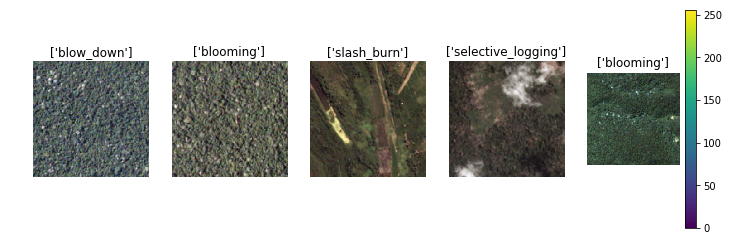

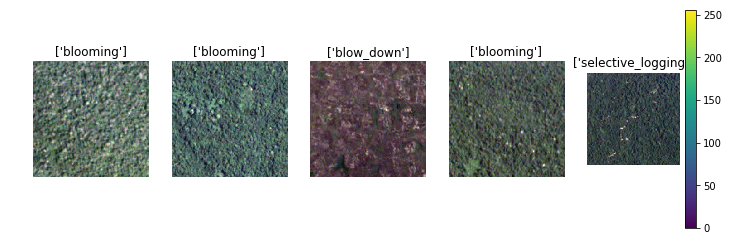

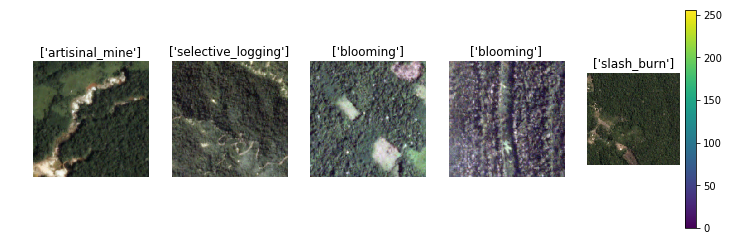

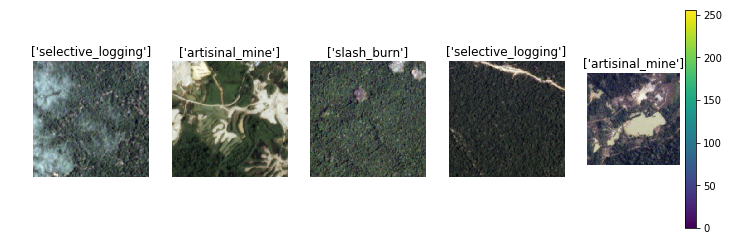

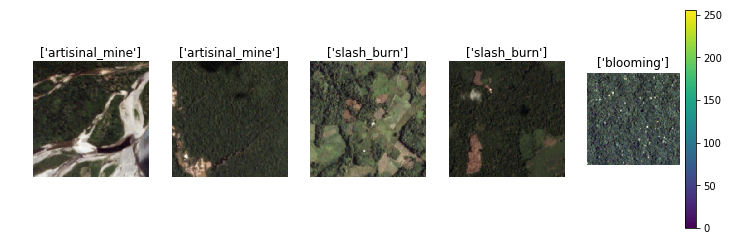

In [15]:
loop_max_counter = 5
for x, y in train_flow:
    
    print('--', x.shape, y.shape)
    print('--', x.min(), x.max(), x.mean(), x.std())
        
    n = 5
    for counter in range(params['batch_size']):
                
        if counter % n == 0:
            plt.figure(figsize=(12, 4))

        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(scale_percentile(img, q_min=0.0, q_max=100.0))
#         plt.imshow(img)
        plt.title("{}".format(np_class_index_tags[np.where(y[counter, :] > 0)]))    
        plt.axis('off')
            
    plt.colorbar()
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

### Generate images as glued pairs

In [12]:
from data_utils import equalized_data_classes

In [13]:
class_index_tags = equalized_data_classes[class_index]
class_index_tags

['artisinal_mine',
 'blooming',
 'blow_down',
 'conventional_mine',
 'selective_logging',
 'slash_burn']

In [14]:
from preproc import generate_glued_pairs

In [16]:
for t in equalized_data_classes[class_index]:
    print("-- t=", t)
    m = TRAIN_ENC_CL_CSV[t]  > 0
    df = TRAIN_ENC_CL_CSV[m]
    id_type_list = get_id_type_list_from_df(df, image_type='Train_tif')    
    generate_glued_pairs(id_type_list, n_generated_files=1000, seed=2017)

-- t= artisinal_mine
-- t= blooming
-- t= blow_down
-- t= conventional_mine
-- t= selective_logging
-- t= slash_burn


In [21]:
from glob import glob
from data_utils import GENERATED_DATA, to_set, get_label

gen_train_jpg_files = glob(os.path.join(GENERATED_DATA, "train", "jpg", "*.jpg"))
gen_train_jpg_ids = [s[len(os.path.join(GENERATED_DATA, "train", "jpg"))+1+len('gen_train_'):-4] for s in gen_train_jpg_files]
gen_id_type_list = [(image_id, "Generated_Train_jpg") for image_id in gen_train_jpg_ids]

In [28]:
class_index = 0

trainval_id_type_list = get_id_type_list_for_class(class_index)

print(len(trainval_id_type_list), len(to_set(trainval_id_type_list)))

1393 1393


In [26]:
class_index_gen_train_jpg_ids = [id_type for id_type in gen_train_jpg_ids if np.sum(get_label(*gen_id_type_list[0], class_index=class_index)) > 0]
class_index_gen_id_type_list = [(image_id, "Generated_Train_jpg") for image_id in class_index_gen_train_jpg_ids]

'10008_18589'

In [30]:
trainval_id_type_list = trainval_id_type_list + class_index_gen_train_jpg_ids

In [31]:
class_indices = list(equalized_data_classes.keys())
class_indices.remove(class_index)

n_other_samples = int(len(trainval_id_type_list) * 1.0 / len(class_indices))

for index in class_indices:
    id_type_list = np.array(get_id_type_list_for_class(index))
    id_type_list = list(to_set(id_type_list) - to_set(trainval_id_type_list))
    np.random.shuffle(id_type_list)
    trainval_id_type_list.extend(id_type_list[:n_other_samples])

print(len(trainval_id_type_list), len(to_set(trainval_id_type_list)))


13724 7812


#### Dev and debug

In [33]:
def to_rgb(img):
    b, g, r, ir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
    out = np.zeros(img.shape[:-1] + (3, ), dtype=img.dtype)
    out[:, :, 0] = r[:, :]
    out[:, :, 1] = g[:, :]
    out[:, :, 2] = b[:, :]
    return out


In [20]:
def create_glued_image(img1, img2, seed=None):
    if seed is not None:
        np.random.seed(seed)  
        
    r = np.random.rand()
    if r > 0.5:
        out = img1.copy()
        overlay = img2
    else:
        out = img2.copy()
        overlay = img1
    index = np.random.randint(0, 2)
    margin = 75
    c = out.shape[index]//2    
    
    # i = np.random.randint(c - margin, c + margin)     # Not really good random
    i = int(np.random.rand() * 2.0 * margin) + c - margin
    dim = out.shape[index] - i
    # j = np.random.randint(0, overlay.shape[index] - dim)     # Not really good random
    j = int(np.random.rand() * (overlay.shape[index] - dim))
    if index == 0:        
        out[i:, :, :] = overlay[j:j+dim, :, :]
    else:
        out[:, i:, :] = overlay[:, j:j+dim, :]
    return out


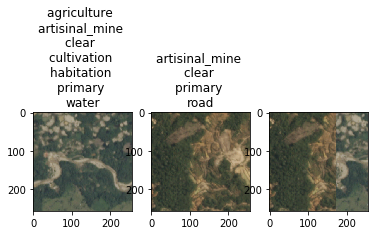

In [21]:
ind1 = 10
ind2 = 2 

img1 = get_image_data(*id_type_list[ind1])
img2 = get_image_data(*id_type_list[ind2])
img = create_glued_image(img1, img2)

c1 = get_caption(*id_type_list[ind1])
c2 = get_caption(*id_type_list[ind2])

plt.figure()
plt.subplot(131)
plt.title(c1.replace(' ', ' \n'))
plt.imshow(img1)
plt.subplot(132)
plt.title(c2.replace(' ', ' \n'))
plt.imshow(img2)
plt.subplot(133)
plt.imshow(img)

In [22]:
from data_utils import get_filename
from image_utils import imwrite


def generate_glued_pairs(id_type_list, n_generated_files, seed=None):
    if seed is not None:
        np.random.seed(seed)  

    counter = n_generated_files
    while counter > 0:
        ind1 = np.random.randint(len(id_type_list))
        ind2 = np.random.randint(len(id_type_list))
        if ind1 == ind2:
            ind2 = (ind2 + np.random.randint(1, len(id_type_list))) % len(id_type_list)
        
        assert id_type_list[ind1][1] == id_type_list[ind2][1], "Image type should be the same: %s != %s" % (id_type_list[ind1][1], id_type_list[ind2][1])
        img1 = get_image_data(*id_type_list[ind1])
        img2 = get_image_data(*id_type_list[ind2])
        img = create_glued_image(img1, img2)
    
        image_id = str(id_type_list[ind1][0]) + "_" + str(id_type_list[ind2][0])
        image_type = 'Generated_' + id_type_list[ind1][1]
    
        filepath = get_filename(image_id, image_type)
        if os.path.exists(filepath):
            # Do not overwrite existing
            continue    
        imwrite(img, image_id, image_type)
        
        counter -= 1



In [317]:
generate_glued_pairs(id_type_list, n_generated_files=1000, seed=2017)

In [17]:
from glob import glob
from data_utils import GENERATED_DATA

gen_train_jpg_files = glob(os.path.join(GENERATED_DATA, "train", "jpg", "*.jpg"))
gen_train_jpg_ids = [s[len(os.path.join(GENERATED_DATA, "train", "jpg"))+1+len('gen_train_'):-4] for s in gen_train_jpg_files]

gen_train_tif_files = glob(os.path.join(GENERATED_DATA, "train", "tif", "*.tif"))
gen_train_tif_ids = [s[len(os.path.join(GENERATED_DATA, "train", "tif"))+1+len('gen_train_'):-4] for s in gen_train_jpg_files]

In [18]:
len(gen_train_jpg_ids), len(gen_train_tif_ids)

(6000, 6000)

In [19]:
# id_type_list = [(image_id, "Generated_Train_jpg") for image_id in gen_train_jpg_ids]
id_type_list = [(image_id, "Generated_Train_tif") for image_id in gen_train_jpg_ids]

In [20]:
from data_utils import get_label

In [21]:
equalized_data_classes[class_index]

['artisinal_mine',
 'blooming',
 'blow_down',
 'conventional_mine',
 'selective_logging',
 'slash_burn']

In [28]:
import numpy as np
from data_utils import np_unique_tags
from image_utils import scale_percentile

In [29]:
image_id = id_type_list[0][0]
image_type = id_type_list[0][1]
as_series = False
class_index = 0

tags = np_unique_tags if class_index is None else np.array(equalized_data_classes[class_index])

_image_ids = image_id.split('_')
_image_type = image_type[len("Generated_"):]
print(_image_ids, _image_type)

_label_1 = get_label(_image_ids[0], _image_type, as_series=as_series)
_label_2 = get_label(_image_ids[1], _image_type, as_series=as_series) 
_label = np.clip(_label_1 + _label_2, 0, 1)
if as_series:
    _label = _label[tags]
else:
    _label = _label[np.where(np.isin(np_unique_tags, tags))]
print(_label)

['10008', '18589'] Train_tif
[1 0 0 0 0 0]


('10008_18589', 'Generated_Train_tif')
('10008_19501', 'Generated_Train_tif')
('10008_20842', 'Generated_Train_tif')
('10008_22765', 'Generated_Train_tif')
('10008_23687', 'Generated_Train_tif')
('10008_37154', 'Generated_Train_tif')
('10051_14036', 'Generated_Train_tif')
('10051_29461', 'Generated_Train_tif')
('10051_6063', 'Generated_Train_tif')
('10064_10712', 'Generated_Train_tif')


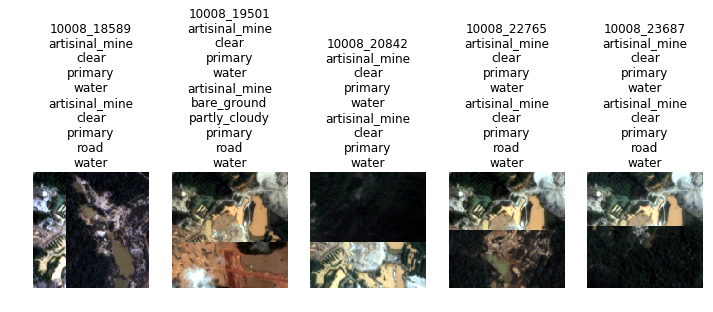

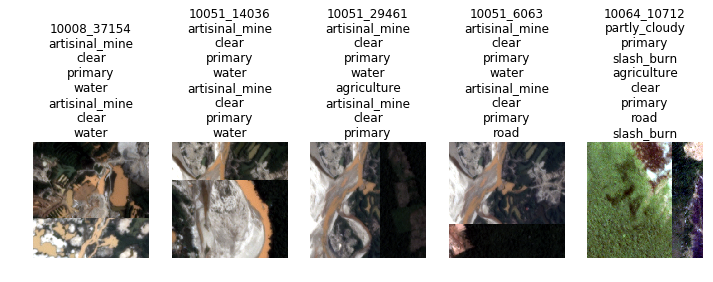

In [35]:
limit_counter = 10

n = 5
for counter in range(limit_counter):

    if counter % n == 0:
        plt.figure(figsize=(12, 4))

    print(id_type_list[counter])
    img = get_image_data(*id_type_list[counter])
    img = to_rgb(img)
    
    image_id = id_type_list[counter][0]
    caption = get_caption(*id_type_list[counter])
    
    plt.subplot(1, n, counter % n + 1)
    plt.imshow(scale_percentile(img, q_min=1.0, q_max=99.0))
#     plt.imshow(img)
#     plt.title("{}".format(get_label(*id_type_list[counter], class_index=class_index)))
    plt.title(image_id + "\n" + caption.replace(' ', '\n'))
    plt.axis('off')
